In [1]:
from datetime import datetime, timezone
import pytz

utc_dt = datetime.now(timezone.utc) # UTC time
dt = utc_dt.astimezone()
tz = pytz.timezone('Europe/Berlin')
berlin_now = datetime.now(tz)
print(f'{berlin_now:%Y-%m-%d %H:%M}')

2022-07-05 11:18


In [2]:
import json
import glob
import os

import urllib.parse
import urllib.request

from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Patch
import seaborn as sns

from Bio import SeqIO
from Bio.SeqUtils import GC

# Exploring horizontal gene transfer in _Spongilla lacustris_; mesocyte candidate genes

How do we reliably detect horizontal gene transfer? According to Sandie Degnan:

> Compelling identification of an HGT-acquired gene thus requires at a minimum: 
> 1) phylogenetic evidence that the candidate gene is more closely related to foreign than to animal genes; 
> 2) genome data showing the candidate gene assembles into a contiguous stretch of DNA with neighboring genes unambiguously of animal origin (this requires, of course, the availability of a sequenced and assembled animal genome; the more complete the assembly, the more confident the HGT identification)
> 3) gene sequence revealing metazoan-like compositional traits, including presence of introns, GC content and codon usage.
> 4) Where possible, gene expression data showing active transcription of candidate genes in animal cell nuclei can enormously strengthen a case, and also addresses the issue of whether or not the HGT-acquired gene is active in its new genomic context, as discussed below.

Point 4) is thankfully a given, since we got the data from single-cell RNA-seq. The transcripts presumably have poly-A tails. It would be great to also have in-situ or HCR confirmation that these are transcribed in _Spongilla_ nuclei or cells, and that they are not in symbionts or free-floating bacteria.

In [3]:
candidates = ['c102757_g1', 'c95037_g1', 'c103983_g1',
              'c95922_g2', 'c97085_g1', 'c97022_g1',
              'c101393_g1', 'c100625_g2', 'c112781_g1',
              'c102838_g2']

annotation = ['emapper: Inherit from COG: Scp-like extracellular | CoFFE: yoaJ',
              'emapper: Cell Wall|CoFFE: sleB', 'emapper: Aminohydrolase',
              'CoFFE: T5orf172', 'emapper: GMHA (phosphoheptose isomerase)',
              'emapper: Metallopeptidase M20 family', 'emapper: BG3',
              'CoFFE: Endochitinase', 'CoFFE: Belongs to the glycosyl hydrolase 5 (cellulase A) family',
              'CoFFE: Chitinase class I']

proposed_origin = ['bacteria', 'bacteria', 'bacteria', 'bacteria', 'bacteria', 'bacteria', 'plants', 'plants', 'plants', 'plants']

phylogeny = pd.DataFrame(data={'gene_id': candidates, 'function': annotation, 'proposed origin': proposed_origin})
phylogeny['extended'] = phylogeny['gene_id'] + ' | ' + phylogeny['function']
phylogeny.set_index('gene_id', inplace=True)

# 1. Phylogenetic evidence

TODO: sequence search against NR

- We found half of these genes in Ephydatia with decent scores. Look in all available sponges! &#x2705;
- also look in algal and bacterial symbionts of sponges, might be interesting stuff in there.
- maybe query the EggNOG orthogroups that gave the annotation to see if there are metazoan genes inside them?
- perform BLASTp searches on NCBI and see what we get &#x2705; save searches &#x2705; and upload to Zenodo or something
- ideally gene trees for every one of those, dunno how much time we really want to invest here

In [4]:
full_species_names = {
    'amphimedon': 'Amphimedon queenslandica',
    'baikalospongia': 'Baikalospongia bacillifera',
    'cymbastella': 'Cymbastella concentrica',
    'ephydatia': 'Ephydatia muelleri',
    'lubomirskiaa': 'Lubomirskia abietina',
    'lubomirskiab': 'Lubomirskia baikalensis',
    'oscarellap': 'Oscarella pearsei',
    'oscarellac': 'Oscarella carmela',
    'scopalina': 'Scopalina sp.',
    'stylissa': 'Stylissa carteri',
    'sycon': 'Sycon ciliatum',
    'tedania': 'Tedania anhelens',
    'tethya': 'Tethya wilhelma',
    'xestospongia': 'Xestospongia testudinaria'   
}

In [5]:
alignments = '/g/arendt/npapadop/data/spongfold_publish/mesocytes/*.m8'
results = []
for alignment in glob.glob(alignments):
    species = os.path.basename(alignment).split('.')[0]
    df = pd.read_csv(alignment, sep="\s+", header=None)
    df.columns = ["query", "target", "seq. id.", "alignment length", "no. mismatches",
                   "no. gap open", "query start", "query end", "target start", "target end",
                   "e value", "bit score"]
    df['species'] = full_species_names[species]
    results.append(df)

sponge_context = pd.concat(results)
sponge_context['gene_id'] = sponge_context['query'].str.split('_').str[:2].apply(lambda x: '_'.join(x))

sponge_context['normalized bit score'] = sponge_context['bit score'] / sponge_context['alignment length']

In [6]:
def best_bit_score(df, sort_by='normalized bit score', tiebreak='alignment length'):
    have_max = df[sort_by] == np.max(df[sort_by])
    max_ali = df[have_max][tiebreak] == np.max(df[have_max][tiebreak])
    return df[have_max][max_ali].index.values[0]

def keep_best(df, groupby='species'):
    df.reset_index(inplace=True)
    idx = df.groupby(groupby).apply(best_bit_score)
    res = df.loc[idx].copy()
    return res

In [7]:
best = sponge_context.groupby('gene_id').apply(keep_best)
best.reset_index(drop=True, inplace=True)
best_per_sponge = best.pivot(index='gene_id', columns='species', values='normalized bit score')
best_per_sponge = best_per_sponge.loc[candidates] # reorder so that all bacteria/plant proposed origins line up
best_per_sponge.fillna(-0.01, inplace=True)

lut = dict(zip(np.unique(proposed_origin), cm.Set1.colors[:2]))
row_colors = phylogeny['proposed origin'].map(lut).values
best_per_sponge.index = phylogeny.loc[best_per_sponge.index]['extended'].values

In [8]:
phylo_order = ['Sycon ciliatum',
'Oscarella pearsei',
'Oscarella carmela',
'Xestospongia testudinaria',
'Amphimedon queenslandica',
'Ephydatia muelleri',
'Baikalospongia bacillifera',
'Lubomirskia baikalensis',
'Lubomirskia abietina',
'Scopalina sp.',
'Stylissa carteri',
'Tethya wilhelma',
'Tedania anhelens',
'Cymbastella concentrica']
best_per_sponge = best_per_sponge[phylo_order]

In [9]:
# best_per_sponge = np.ma.masked_where(best_per_sponge == 0, best_per_sponge)

cmap = cm.get_cmap('magma_r').copy()
cmap.set_under(color='white')

In [10]:
# best_per_sponge = best_per_sponge[['Ephydatia muelleri', 'Baikalospongia bacillifera', 'Lubomirskia abietina',
#                                    'Lubomirskia baikalensis', 'Cymbastella concentrica', 'Scopalina sp.',
#                                    'Stylissa carteri', 'Xestospongia testudinaria', 'Tedania anhelens',
#                                    'Amphimedon queenslandica']]

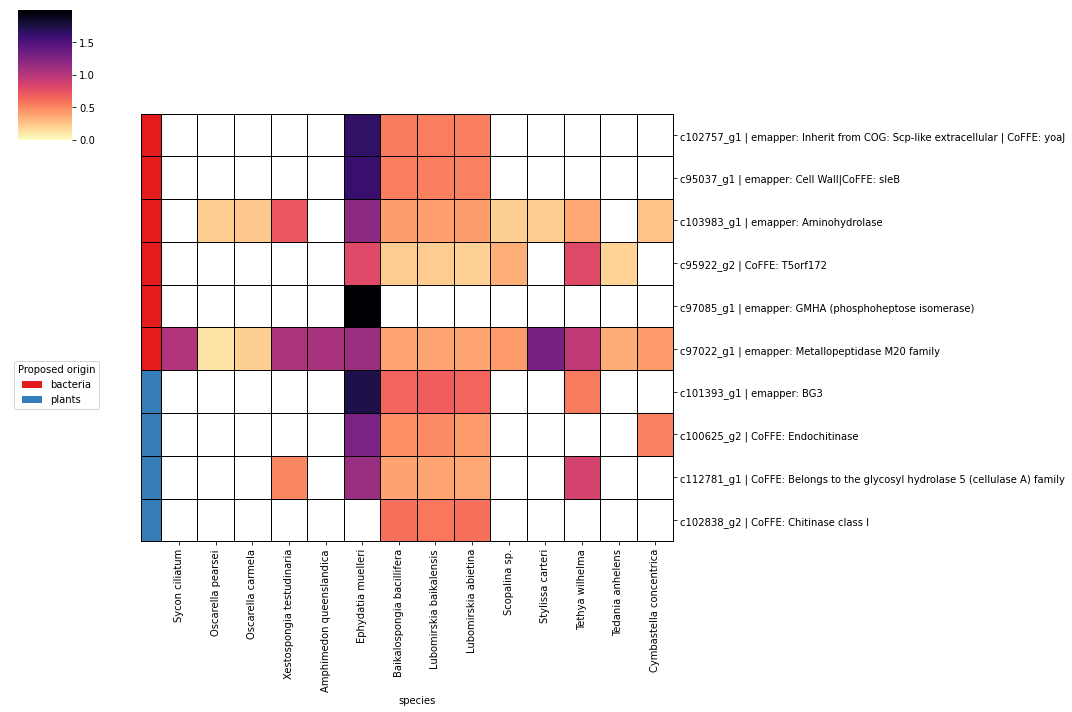

In [12]:
sns.clustermap(best_per_sponge, cmap=cmap, row_colors=row_colors, row_cluster=False, col_cluster=False,
               figsize=(15, 10), vmin=0, linewidth=1, linecolor='black', clip_on=False)
handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='Proposed origin',
           bbox_to_anchor=(0.1, 0.5), bbox_transform=plt.gcf().transFigure, loc='upper right')
plt.savefig('./figures/analysis-hgt_phylogeny.pdf')

This demonstrates that these genes are present in other sponges too; they don't look like contaminants. We still need to add metazoa, bacteria, algae, and fungi to make sure.

# 2. Genome data

Check! It is in-house stuff, so we can at least reference it.

# 3. Metazoan-like compositional traits

In [13]:
transcriptome_loc = '/g/arendt/npapadop/data/spongfold_publish/Spongilla_lacustris_Trinity_transcriptome.fasta'
records = list(SeqIO.parse(transcriptome_loc, 'fasta'))

In [14]:
seq_id = [''] * len(records)
gene_id = [''] * len(records)
transcript = [''] * len(records)

for i, r in enumerate(tqdm(records)):
    seq_id[i] = r.id
    gene_id[i] = '_'.join(r.id.split('_')[:2])
    transcript[i] = str(r.seq)

transcriptome = pd.DataFrame({'seq_id': seq_id, 'gene_id': gene_id, 'transcript': transcript})

100%|██████████| 62180/62180 [00:00<00:00, 571291.12it/s]


## 3.1 Presence of introns

no genome :(

## 3.2 GC content

Not sure how we compare to metazoan GC content. We can at least see if the candidates are clear outliers as far as Spongilla is concerned.

In [15]:
transcriptome['GC'] = transcriptome['transcript'].apply(GC)

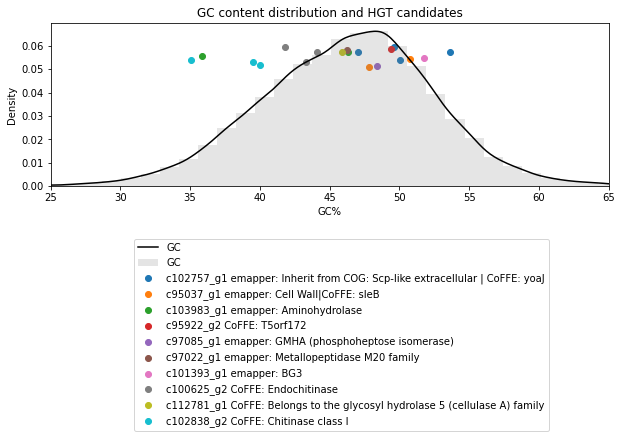

In [16]:
fig, ax = plt.subplots(figsize=(10, 3))
transcriptome['GC'].plot(kind='hist', ax=ax, density=True, bins=50, alpha=0.2, facecolor='gray')
transcriptome['GC'].plot(kind='kde', ax=ax, c='black')
for gene, name in zip(candidates, annotation):
    tmp = transcriptome[transcriptome['gene_id'] == gene]['GC']
    xs = tmp.values
    ys = np.ones(len(xs)) * 0.05 + np.random.uniform(0, 0.01, size=len(xs))
    ax.scatter(xs, ys, label=gene + ' ' + name)

ax.set_title('GC content distribution and HGT candidates')
ax.set_xlim(25, 65)
ax.set_xlabel('GC%')
ax.legend(loc=(0.15, -1.5));

## 3.3 Codon usage

Not sure how we compare to metazoan codon usage. We can at least see if the candidates are clear outliers as far as Spongilla is concerned.

From [wikipedia](https://en.wikipedia.org/wiki/Codon_Adaptation_Index):

> Codon Adaptation Index is the most widespread technique for analysing codon usage bias. [...] CAI measures the deviation of each protein coding gene sequence from a reference set of highly expressed genes. [...] The assumption is that highly expressed genes need to compete for resources (e.g. ribosomes) in fast-growing organisms, and it makes sense for them to also be more accurately translated. Both hypotheses lead to highly expressed genes preferring to use codons that are very abundant in the cell.

So first let's use the single cell data to find highly expressed genes:

In [17]:
import scanpy as sc

In [18]:
adata = sc.read('../data/spongilla_basic.h5ad')

In [19]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

In [20]:
keep = adata.var['total_counts'] > 20000
highly_expressed = adata.var[keep].index.str.split().str[0].str.replace('-', '_')

highly_expressed_isoforms = transcriptome['seq_id'][transcriptome['gene_id'].isin(highly_expressed)]

In [21]:
def find_longest_orf(seq, trans_table=11):
    answer = ''
    seq_len = len(seq)
    longest = 0
    for strand, nuc in [(+1, seq), (-1, seq.reverse_complement())]:
        for frame in range(3):
            trans = nuc[frame:].translate(trans_table)
            trans_len = len(trans)
            aa_start = 0
            aa_end = 0
            while aa_start < trans_len:
                aa_end = trans.find("*", aa_start)
                if aa_end == -1:
                    aa_end = trans_len
                if aa_end - aa_start > longest:
                    longest = aa_end - aa_start
                    start = frame + aa_start * 3
                    end = min(seq_len, frame + aa_end * 3 + 3)
                    end = end - ((end-start) % 3)
                    answer = nuc[start:end]
#                     print(strand, frame, start, end, longest)
                aa_start = aa_end + 1
    return answer

We need to find the longest ORF per gene, though we'll create our index off of highly expressed genes only:

In [22]:
longest_orf = {}
for i, record in enumerate(tqdm(records)):
    longest = find_longest_orf(record.seq)
    if len(longest) % 3 != 0:
        break
    longest_orf[record.id] = longest

  0%|          | 0/62180 [00:00<?, ?it/s]/home/npapadop/.local/lib/python3.9/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
100%|██████████| 62180/62180 [00:37<00:00, 1652.97it/s]


Create a list of longest ORFs for the highly expressed genes and calculate the index:

In [23]:
highly_expressed_records = [longest_orf[i] for i in highly_expressed_isoforms]

In [24]:
with open('../data/codon_background.fasta', 'w') as fasta:
    for isoform in highly_expressed_isoforms:
        fasta.write('>' + isoform + '\n')
        fasta.write(str(longest_orf[isoform]) + '\n')

In [25]:
from Bio.SeqUtils.CodonUsage import CodonAdaptationIndex

In [26]:
cai = CodonAdaptationIndex()
cai.generate_index('../data/codon_background.fasta')

Now let's calculate the CAI for each gene's longest ORF:

In [27]:
cai_single = [0] * len(records)

for i, orf in enumerate(tqdm(longest_orf.values())):
    cai_single[i] = cai.cai_for_gene(str(orf))

transcriptome['CAI'] = cai_single

100%|██████████| 62180/62180 [00:04<00:00, 13107.61it/s]


Let's plot GC content versus CAI index and see if any of our candidate genes are outliers:

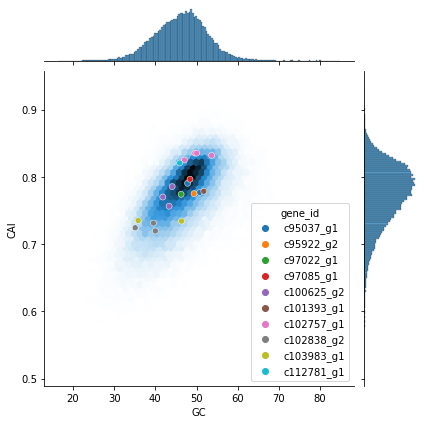

In [28]:
# fig, ax = plt.subplots()
g = sns.jointplot(data=transcriptome, x='GC', y='CAI', kind='hex')
df = transcriptome[transcriptome['gene_id'].isin(candidates)]
sns.scatterplot(data=df, x='GC', y='CAI', hue='gene_id')
plt.savefig('./figures/analysis-hgt_CAI_GC.pdf')